In [1]:
from qgis.core import QgsVectorLayer,QgsField,edit
from qgis.PyQt.QtCore import QVariant
from paras_2 import decay_tree_potential,NP_retention
from smk_geotools import hsAnalysis
import numpy as np

#for developing
import geopandas as gpd
import matplotlib.pyplot as plt
from qgis.core import QgsVectorFileWriter

<>:2: DeprecationWarning: invalid escape sequence \R
<>:2: DeprecationWarning: invalid escape sequence \R
C:\Users\mjkesala\AppData\Local\Temp\ipykernel_1752\239189533.py:2: DeprecationWarning: invalid escape sequence \R
  data_example = "data_example\ReTreeT.gpkg"


<AxesSubplot:>

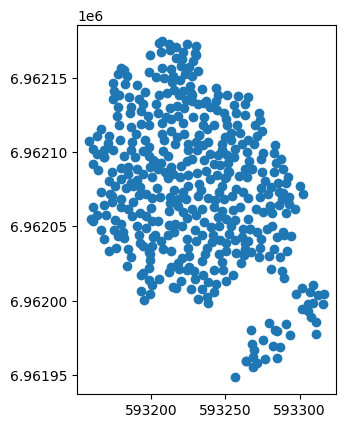

In [2]:
#example cutting area
data_example = "data_example\ReTreeT.gpkg"
layer = "treemap"
data_qgis = QgsVectorLayer(data_example+"|layername="+layer,"treemap","ogr")
data_df = gpd.read_file(data_example,layer = layer)

data_df

data_df.plot()

In [3]:
data_df

,CHM,SPECIALFEATURECODE,SPECIALFEATUREADDITIONALCODE,FERTILITYCLASS,DEVELOPMENTCLASS,STEMCOUNTPINE,STEMCOUNTDECIDUOUS,STEMCOUNTSPRUCE,MEANDIAMETERDECIDUOUS,MEANDIAMETERPINE,...,euc_1,DTW_1n,biod,biodn,dtree,dtreen,pRetent,pRetentn,env_value,geometry
0,97,None,None,4,02,1453.0,NaN,NaN,NaN,11.46,...,52.0,0.914048,0.000000,0.000000,0.132318,0.050933,0.437349,0.283594,1.248576,POINT (593161.000 6962063.000)
1,81,None,None,4,02,1453.0,NaN,NaN,NaN,11.46,...,44.0,0.940321,0.000000,0.000000,0.132318,0.050933,0.449920,0.291746,1.283000,POINT (593161.000 6962053.500)
2,81,None,None,4,02,1453.0,NaN,NaN,NaN,11.46,...,46.0,0.924714,0.000000,0.000000,0.132318,0.050933,0.442453,0.286904,1.262551,POINT (593159.500 6962055.000)
3,97,None,None,4,02,1453.0,NaN,NaN,NaN,11.46,...,48.0,0.938038,0.000000,0.000000,0.132318,0.050933,0.448828,0.291038,1.280009,POINT (593163.500 6962057.500)
4,144,None,None,4,03,1168.0,NaN,10.0,NaN,16.59,...,45.0,0.930900,0.037034,0.034039,0.277875,0.106961,0.445412,0.288823,1.360723,POINT (593179.857 6962051.500)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,169,None,None,4,03,478.0,7.0,101.0,7.5,23.24,...,106.0,0.367483,0.502895,0.462217,1.080165,0.415784,0.175831,0.114016,1.359500,POINT (593235.500 6962094.500)
441,218,None,None,4,03,478.0,7.0,101.0,7.5,23.24,...,100.0,0.570593,0.502895,0.462217,1.080165,0.415784,0.273015,0.177033,1.625628,POINT (593236.833 6962087.389)
442,227,None,None,4,03,478.0,7.0,101.0,7.5,23.24,...,98.0,0.612452,0.502895,0.462217,1.080165,0.415784,0.293043,0.190020,1.680474,POINT (593239.389 6962082.167)
443,220,None,None,4,03,478.0,7.0,101.0,7.5,23.24,...,103.0,0.518528,0.502895,0.462217,1.080165,0.415784,0.248103,0.160880,1.557409,POINT (593244.375 6962084.625)


In [4]:
def limit(x,minimum,maximum):
    fc = lambda x : x if x>minimum and x<maximum else (minimum if x<=minimum else maximum)
    
    return fc(x)

In [6]:
def normalizeValue(in_feat:QgsVectorLayer,fieldname:str,filtervalues:tuple,transpose:bool=False):
    """
    This normalize values between 0 and 1 by formula f(x) = x-min(x) / max(x) - min(x)
    You can limit values between specific values and transpose the values
    """
    in_feat.dataProvider().addAttributes([QgsField(fieldname+"n",QVariant.Double)])
    in_feat.updateFields()
    
    lis = [feat[fieldname] for feat in in_feat.getFeatures() if feat[fieldname] is not None]
    
    #print (lis)
    if filtervalues is not None:
        lis = [limit(i,filtervalues[0],filtervalues[1]) for i in lis]
        with edit(in_feat):
            for feat in in_feat.getFeatures():
                feat[fieldname]=limit(feat[fieldname],filtervalues[0],filtervalues[1])
                in_feat.updateFeature(feat)
                
    try:
        minlis = min(list(lis))
        maxlis = max(list(lis))
        
    except:
        minlis = 0
        maxlis = 1
    
    
    with edit(in_feat):
        for feat in in_feat.getFeatures():
            if feat[fieldname] is not None:
                if transpose == False:
                    feat[fieldname+"n"] = (feat[fieldname]-minlis) / (maxlis-minlis)
                else:
                    feat[fieldname+"n"] = 1- ((feat[fieldname]-minlis) / (maxlis-minlis))
            else:
                feat[fieldname+"n"] = 0.0
            
            in_feat.updateFeature(feat)


        DTW_1    DTW_1n
0    0.068761  0.914048
1    0.047743  0.940321
2    0.060228  0.924714
3    0.049569  0.938038
4    0.055280  0.930900
..        ...       ...
440  0.506014  0.367483
441  0.343525  0.570593
442  0.310039  0.612452
443  0.385177  0.518528
444  0.421289  0.473389

[445 rows x 2 columns]


(array([ 57.,   4.,  25.,  27.,  35.,  29.,  28.,  42., 102.,  96.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

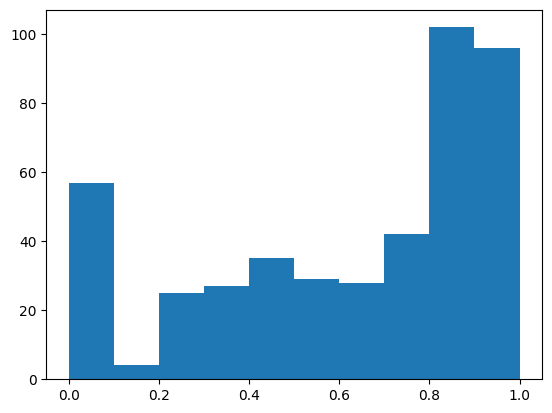

In [6]:
#we test about normalization of DTW value
normalizeValue(data_qgis,"DTW_1",(0.0,0.8),True)

data_df = gpd.read_file(data_example,layer = layer)
t = data_df[['DTW_1','DTW_1n']]#where(data_df['DTW_1n']<0,inplace=True)

print (t)

plt.hist(data_df["DTW_1n"])

In [7]:
def simpson_di(species):
    """
    This calculates simpson diversity index by formula D = n(n-1)/N(N-1)
    Species list are form of [10,1,3,4]
    """
    
    proportions = [i/sum(species) for i in species]
    simpsons_index = 0
    for proportion in proportions:
        simpsons_index += proportion ** 2
    
    return (1 - simpsons_index) / (1-1/len(species)) if simpsons_index > 0 and len(species)>1 else 0


In [8]:
def calculateBiodiversity(in_feat:QgsVectorLayer,speciesfield:list):
    """
    This calculates specific diversity index by given species list and save it to given QgsVectorLayer.
    Species list have to be format of [1,35,42,2,23,...,n]
    """
    
    in_feat.dataProvider().addAttributes([QgsField("biod",QVariant.Double)])
    in_feat.updateFields()
    
    with edit(in_feat):
        for feat in in_feat.getFeatures():
            
            sim_di = simpson_di([feat[i] for i in speciesfield if feat[i] > 0])
            if feat['SPECIALFEATURECODE'] is not None:
                conver_cof = sim_di * 0.1
            else:
                conver_cof = 0
            
            feat['biod'] = float(sim_di+conver_cof)
            in_feat.updateFeature(feat)
    
    normalizeValue(in_feat,'biod',None,False)

        biodn      biod
0    0.000000  0.000000
1    0.000000  0.000000
2    0.000000  0.000000
3    0.000000  0.000000
4    0.034039  0.037034
..        ...       ...
440  0.462217  0.502895
441  0.462217  0.502895
442  0.462217  0.502895
443  0.462217  0.502895
444  0.462217  0.502895

[445 rows x 2 columns]


(array([70., 39., 79., 72., 39., 22., 22., 43., 33., 26.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

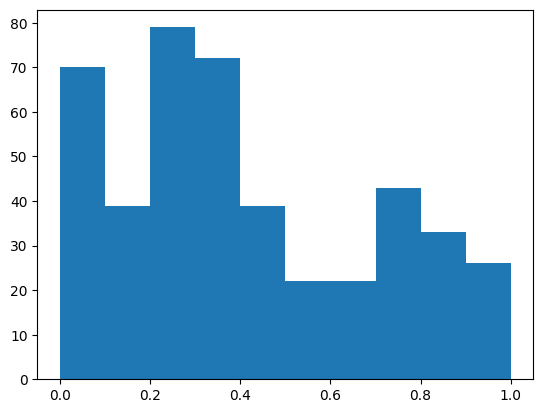

In [12]:
calculateBiodiversity(data_qgis,["STEMCOUNTPINE","STEMCOUNTDECIDUOUS","STEMCOUNTSPRUCE"])


data_df = gpd.read_file(data_example,layer = layer)
print (data_df[['biodn','biod']])
plt.hist(data_df["biodn"])

In [9]:
def calculateDecayTreePotential(in_feat):
    
    in_feat.dataProvider().addAttributes([QgsField("dtree",QVariant.Double)])
    in_feat.updateFields()
    
    #treelist = [1,2,29]
    puuH = [("MEANHEIGHTPINE",1),("MEANHEIGHTSPRUCE",2),("MEANHEIGHTDECIDUOUS",29)]
    fc_d = lambda t : t.replace("HEIGHT","DIAMETER")
    fc_v = lambda t : t.replace("HEIGHT","VOLUME")
    
    with edit(in_feat):
        for feat in in_feat.getFeatures():

            dcp = decay_tree_potential('zone'+str(feat['PaajakoNro']))

            if feat['FERTILITYCLASS'] > 0 and max([feat[p[0]] for p in puuH]) >0:
                if feat['FERTILITYCLASS']>6:
                    para = [dcp[6][i[1]] for i in puuH]
                else:
                    para = [dcp[int(feat['FERTILITYCLASS'])][i[1]] for i in puuH]
                                    
                potvalues = [limit(np.poly1d(para[i])(feat[fc_d(p[0])]),0,2) for i,p in enumerate(puuH) if feat[fc_d(p[0])] > 0]
                
            else:
                potvalues=[0]
            
            feat["dtree"]=float(sum(potvalues))
            
            
            in_feat.updateFeature(feat)
    
    normalizeValue(in_feat,"dtree",None,False)


0      0.050933
1      0.050933
2      0.050933
3      0.050933
4      0.106961
         ...   
440    0.415784
441    0.415784
442    0.415784
443    0.415784
444    0.415784
Name: dtreen, Length: 445, dtype: float64


(array([ 18.,  43., 142.,  45.,  28.,  28.,   1.,   7.,  10., 123.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

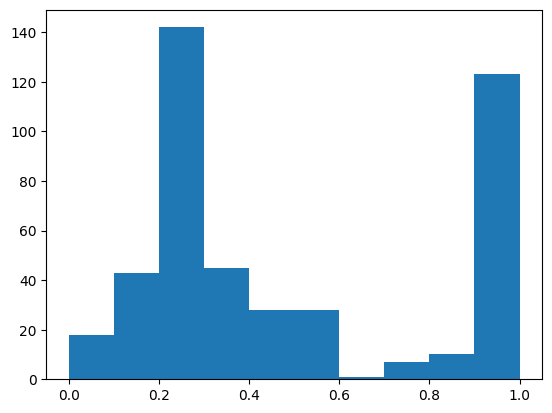

In [15]:
calculateDecayTreePotential(data_qgis)

data_df = gpd.read_file(data_example,layer = layer)

print(data_df['dtreen'])

plt.hist(data_df['dtreen'])

In [10]:
def calculateNPretention(in_feat):
    in_feat.dataProvider().addAttributes([QgsField("pRetent",QVariant.Double)])
    in_feat.updateFields()
    ret = NP_retention()
    with edit(in_feat):
        for feat in in_feat.getFeatures():
            if type(feat['euc_1']) in (float,int):
                feat['pRetent'] = ret['P']/limit(feat['euc_1'],0,40) * feat['DTW_1n']
                
            in_feat.updateFeature(feat)
    
    normalizeValue(in_feat,'pRetent',None,False)


     pRetentn   pRetent  euc_1
0    0.283594  0.437349   52.0
1    0.291746  0.449920   44.0
2    0.286904  0.442453   46.0
3    0.291038  0.448828   48.0
4    0.288823  0.445412   45.0
..        ...       ...    ...
440  0.114016  0.175831  106.0
441  0.177033  0.273015  100.0
442  0.190020  0.293043   98.0
443  0.160880  0.248103  103.0
444  0.146875  0.226505  109.0

[445 rows x 3 columns]


(array([ 89., 102., 202.,  40.,   6.,   4.,   0.,   0.,   0.,   2.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

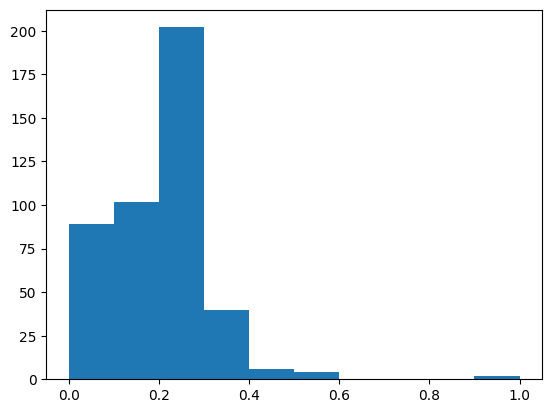

In [17]:
calculateNPretention(data_qgis)

data_df = gpd.read_file(data_example,layer = layer)

print(data_df[['pRetentn','pRetent','euc_1']])

plt.hist(data_df['pRetentn'])

In [11]:
def calculateEnvValue(in_feat,weights):
    in_feat.dataProvider().addAttributes([QgsField("env_value",QVariant.Double)])
    in_feat.updateFields()

    with edit(in_feat):
        for feat in in_feat.getFeatures():
            feat['env_value'] = feat['biodn']*weights['BIO']+feat['pRetentn']*weights['NP']+feat['DTW_1n']*weights['DTW']+feat['dtreen']*weights['LP']
            
            #normalizeValue(in_feat,'env_value',None,False)
            in_feat.updateFeature(feat)

0      1.248576
1      1.283000
2      1.262551
3      1.280009
4      1.360723
         ...   
440    1.359500
441    1.625628
442    1.680474
443    1.557409
444    1.498264
Name: env_value, Length: 445, dtype: float64


(array([  3.,   9.,   8., 102., 101.,  92.,  68.,  29.,  11.,  22.]),
 array([0.        , 0.33072927, 0.66145854, 0.99218782, 1.32291709,
        1.65364636, 1.98437563, 2.31510491, 2.64583418, 2.97656345,
        3.30729272]),
 <BarContainer object of 10 artists>)

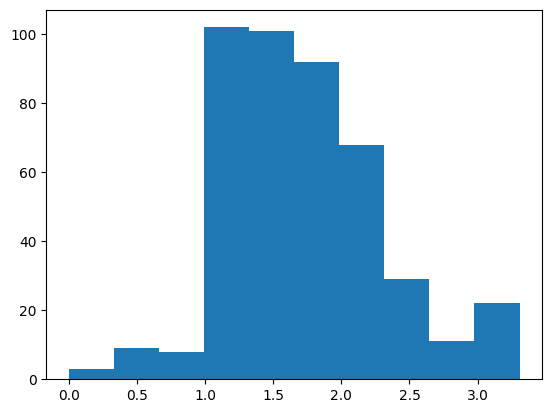

In [30]:
weights ={"NP":float(1),"BIO":float(1),"LP":float(1),"DTW":float(1)}
calculateEnvValue(data_qgis,weights)

data_df = gpd.read_file(data_example,layer = layer)

print(data_df['env_value'])

plt.hist(data_df['env_value'])

<AxesSubplot:>

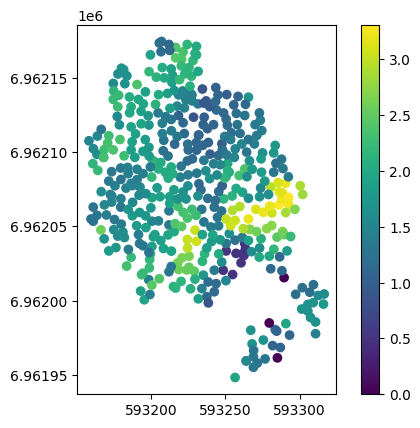

In [4]:
data_df.plot(column='env_value',legend=True)

In [12]:
hs = hsAnalysis(data_qgis,'env_value')

geop = data_example

options = QgsVectorFileWriter.SaveVectorOptions()
options.actionOnExistingFile = QgsVectorFileWriter.CreateOrOverwriteLayer

if QgsVectorFileWriter.writeAsVectorFormat(hs, geop, options):
    print("Vector layer saved to GeoPackage successfully.")
else:
    print("Error saving vector layer to GeoPackage.")

\\ad.helsinki.fi\home\m\mjkesala\Documents\GitHub\smk_tools\processing\smk_geotools.py:167: ResourceWarning: unclosed file <_io.BufferedRandom name=4>
  tempd = tempd.name+'.tif'
C:\Users\mjkesala\AppData\Local\Temp\ipykernel_17036\298268678.py:8: DeprecationWarning: QgsVectorFileWriter.writeAsVectorFormat() is deprecated
  if QgsVectorFileWriter.writeAsVectorFormat(hs, geop, options):


Vector layer saved to GeoPackage successfully.


         HS_1  env_value
0    1.257642   1.248576
1    1.305860   1.283000
2    1.263717   1.262551
3    1.298078   1.280009
4    1.385427   1.360723
..        ...        ...
440  1.374194   1.359500
441  1.621716   1.625628
442  1.674860   1.680474
443  1.579321   1.557409
444  1.520965   1.498264

[445 rows x 2 columns]


<AxesSubplot:>

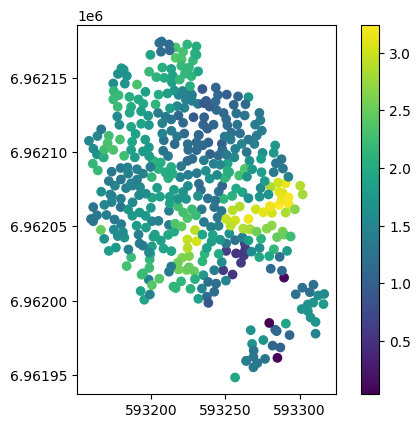

In [19]:
layer2 = "ReTreeT"
data_qgis2 = QgsVectorLayer(data_example+"|layername="+layer,"treemap","ogr")
data_df2 = gpd.read_file(data_example,layer = layer2)

print(data_df2[['HS_1','env_value']])

data_df2.plot(column='HS_1',legend=True)

In [15]:
def selectReTrees(in_feat:QgsVectorLayer,fieldname:str,cuttingfield:str,treecount:int,cuttingsize:float):
    """
    This select retention trees by given QgsVectorLayer, fieldname and treecount. Parameter "cuttingfield" restrict selection to cutting area 
    """
    
    in_feat.dataProvider().addAttributes([QgsField("reTree",QVariant.Int)])
    in_feat.updateFields()

    #Restrict to cutting area
    NoLeim = [feat.id() for feat in in_feat.getFeatures() if feat[cuttingfield]!=1]
    in_feat.dataProvider().deleteFeatures(NoLeim)
    in_feat.updateFields()

    #getting to values in which we do the selection
    opt = np.array([feat[fieldname] for feat in in_feat.getFeatures()])

    treecount = int(round(float(treecount) * float(cuttingsize),0))
    pvalue = opt[np.argsort(opt)[-treecount]]
    
    
    with edit(in_feat):
        for feat in in_feat.getFeatures():
            if feat[fieldname]>=pvalue:
                feat['reTree']=1
            else:
                feat['reTree']=0
            in_feat.updateFeature(feat)
    
    return in_feat
    

In [23]:
selectReTrees(data_qgis2,'HS_1','leimikko',10,2.4)
data_df2 = gpd.read_file(data_example,layer = layer2)
data_df2.plot(column='reTree',legend=True)

KeyError: 'HS_1'

In [14]:
def runEssModel(in_feat:QgsVectorLayer,weights,treecount,cuttingsize):
    normalizeValue(in_feat,"DTW_1",(0.0,0.8),True)
    calculateBiodiversity(in_feat,["STEMCOUNTPINE","STEMCOUNTDECIDUOUS","STEMCOUNTSPRUCE"])
    calculateDecayTreePotential(in_feat)
    calculateNPretention(in_feat)
    #weights ={"NP":float(1),"BIO":float(1),"LP":float(1),"DTW":float(1)}
    calculateEnvValue(in_feat,weights)
    retrees = hsAnalysis(in_feat,'env_value')
    selectReTrees(retrees,'HS_1','leimikko',treecount,cuttingsize)

    return retrees

    
    


    
    

\\ad.helsinki.fi\home\m\mjkesala\Documents\GitHub\smk_tools\processing\smk_geotools.py:167: ResourceWarning: unclosed file <_io.BufferedRandom name=4>
  tempd = tempd.name+'.tif'
C:\Users\mjkesala\AppData\Local\Temp\ipykernel_17036\411374423.py:8: DeprecationWarning: QgsVectorFileWriter.writeAsVectorFormat() is deprecated
  if QgsVectorFileWriter.writeAsVectorFormat(hs, geop, options):


Vector layer saved to GeoPackage successfully.


KeyError: 'reTree'

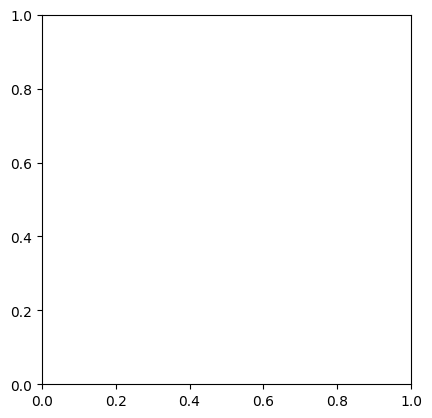

In [21]:
weights ={"NP":float(1),"BIO":float(1),"LP":float(1),"DTW":float(1)}
rtreet = runEssModel(data_qgis,weights,15,2.3)
#rtreet.setName("trees")

options = QgsVectorFileWriter.SaveVectorOptions()
options.actionOnExistingFile = QgsVectorFileWriter.CreateOrOverwriteLayer

if QgsVectorFileWriter.writeAsVectorFormat(hs, geop, options):
    print("Vector layer saved to GeoPackage successfully.")
else:
    print("Error saving vector layer to GeoPackage.")

data_df2 = gpd.read_file(data_example,layer = 'ReTreeT')
data_df2.plot(column='reTree',legend=True)

In [20]:
data_df2

,CHM,SPECIALFEATURECODE,SPECIALFEATUREADDITIONALCODE,FERTILITYCLASS,DEVELOPMENTCLASS,STEMCOUNTPINE,STEMCOUNTDECIDUOUS,STEMCOUNTSPRUCE,MEANDIAMETERDECIDUOUS,MEANDIAMETERPINE,...,DTW_1n,biod,biodn,dtree,dtreen,pRetent,pRetentn,env_value,HS_1,geometry
0,97,None,None,4,02,1453.0,NaN,NaN,NaN,11.46,...,0.914048,0.000000,0.000000,0.132318,0.050933,0.437349,0.283594,1.248576,1.257642,POINT (593161.000 6962063.000)
1,81,None,None,4,02,1453.0,NaN,NaN,NaN,11.46,...,0.940321,0.000000,0.000000,0.132318,0.050933,0.449920,0.291746,1.283000,1.305860,POINT (593161.000 6962053.500)
2,81,None,None,4,02,1453.0,NaN,NaN,NaN,11.46,...,0.924714,0.000000,0.000000,0.132318,0.050933,0.442453,0.286904,1.262551,1.263717,POINT (593159.500 6962055.000)
3,97,None,None,4,02,1453.0,NaN,NaN,NaN,11.46,...,0.938038,0.000000,0.000000,0.132318,0.050933,0.448828,0.291038,1.280009,1.298078,POINT (593163.500 6962057.500)
4,144,None,None,4,03,1168.0,NaN,10.0,NaN,16.59,...,0.930900,0.037034,0.034039,0.277875,0.106961,0.445412,0.288823,1.360723,1.385427,POINT (593179.857 6962051.500)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,169,None,None,4,03,478.0,7.0,101.0,7.5,23.24,...,0.367483,0.502895,0.462217,1.080165,0.415784,0.175831,0.114016,1.359500,1.374194,POINT (593235.500 6962094.500)
441,218,None,None,4,03,478.0,7.0,101.0,7.5,23.24,...,0.570593,0.502895,0.462217,1.080165,0.415784,0.273015,0.177033,1.625628,1.621716,POINT (593236.833 6962087.389)
442,227,None,None,4,03,478.0,7.0,101.0,7.5,23.24,...,0.612452,0.502895,0.462217,1.080165,0.415784,0.293043,0.190020,1.680474,1.674860,POINT (593239.389 6962082.167)
443,220,None,None,4,03,478.0,7.0,101.0,7.5,23.24,...,0.518528,0.502895,0.462217,1.080165,0.415784,0.248103,0.160880,1.557409,1.579321,POINT (593244.375 6962084.625)
